<a href="https://colab.research.google.com/github/hafiez2109/Data-Engineering/blob/main/ETL__for__Etsy's__Shoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GROUP PROJECT - ETL (WEB SCRAPPING)**

GROUP MEMBER

1. ISKANDAR HAZRYLL BIN NAZRIZAL (A188532)
2. MUHAMMAD HAFIEZ BIN ABU HASSAN (A187291)
3. NUR AMIRA NADIA BINTI AHLAN (A187911)
4. NURULAMIRA BINTI MOHD MISRAN (A188250)

### **1. INSTALL BEAUTIFUL SOUP**

In [ ]:
!pip install beautifulsoup4


## **2. IMPORT LIBRARIES THAT ARE REQUIRED**

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from PIL import Image
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

## **3. EXTRACT DATA FROM WEBSITE**

In [ ]:
base_url = "https://www.etsy.com/c/shoes?ref=pagination&page="

# Set the range of pages you want to scrape (up to page 50)
start_page = 1
end_page = 20

# Loop through the pages
for page_number in range(start_page, end_page + 1):
    # Construct the URL for the current page
    current_url = f"{base_url}{page_number}"

    # Send an HTTP GET request to the URL
    response = requests.get(current_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the pagination links for the next iteration
        pagination_links = soup.select('ul.wt-action-group a[data-page]')

        # Extract and print the unique links in sequential order
        unique_links = set()
        for link in pagination_links:
            next_page_number = link.get('data-page')
            next_page_url = link.get('href')
            unique_links.add((next_page_number, next_page_url))

        # Sort the unique links by page number
        sorted_links = sorted(unique_links, key=lambda x: int(x[0]))

        # Print the sorted links for verification
        for next_page_number, next_page_url in sorted_links:
            print(f"Next Page {next_page_number}: {next_page_url}")

Next Page 1: https://www.etsy.com/c/shoes?ref=pagination&page=1
Next Page 3: https://www.etsy.com/c/shoes?ref=pagination&page=3
Next Page 4: https://www.etsy.com/c/shoes?ref=pagination&page=4
Next Page 5: https://www.etsy.com/c/shoes?ref=pagination&page=5
Next Page 6: https://www.etsy.com/c/shoes?ref=pagination&page=6
Next Page 7: https://www.etsy.com/c/shoes?ref=pagination&page=7
Next Page 8: https://www.etsy.com/c/shoes?ref=pagination&page=8
Next Page 1: https://www.etsy.com/c/shoes?ref=pagination&page=1
Next Page 2: https://www.etsy.com/c/shoes?ref=pagination&page=2
Next Page 4: https://www.etsy.com/c/shoes?ref=pagination&page=4
Next Page 5: https://www.etsy.com/c/shoes?ref=pagination&page=5
Next Page 6: https://www.etsy.com/c/shoes?ref=pagination&page=6
Next Page 7: https://www.etsy.com/c/shoes?ref=pagination&page=7
Next Page 8: https://www.etsy.com/c/shoes?ref=pagination&page=8
Next Page 2: https://www.etsy.com/c/shoes?ref=pagination&page=2
Next Page 3: https://www.etsy.com/c/shoe

In [ ]:
# Static exchange rate
usd_to_myr_exchange_rate = 4.59

In [ ]:
def extract_product_info(container, usd_to_myr_exchange_rate):
    product_info = {}

    # Extracting shop ID
    shop_id_tag = container.find("div", {'data-shop-id': True})
    product_info['Shop ID'] = shop_id_tag['data-shop-id'] if shop_id_tag else None

    # Extracting product names
    names = container.find("h3", class_="wt-text-caption")
    product_info['Name'] = names.text.strip() if names else None

    # Extracting prices
    prices = container.find("span", class_="currency-value")
    product_info['Price'] = prices.text if prices else None

    # Extracting original prices
    oriprice = container.find("span", class_="wt-text-strikethrough")
    original_price_str = oriprice.text.strip() if oriprice else None
    product_info['OriginalPrice'] = convert_currency(original_price_str, usd_to_myr_exchange_rate) if original_price_str else None

    # Extracting number of reviews
    reviews = container.find("span", class_="wt-text-caption wt-text-gray wt-display-inline-block wt-nudge-l-3 wt-pr-xs-1")
    product_info['NumberOfReviews'] = reviews.text.strip().replace('(', '').replace(')', '') if reviews else None

    # Extracting product shipping status
    ship = container.find("span", class_="wt-badge wt-badge--small wt-badge--statusValue")
    product_info['ShipStatus'] = ship.text.strip() if ship else None

    # Extracting product star seller
    starseller = container.find("p", class_="wt-text-caption-title wt-nudge-l-2 star-seller-badge-lavender-text-light")
    product_info['StarSeller'] = starseller.text.strip() if starseller else None

    # Extracting product recommended
    rec = container.find("span", class_="wt-badge wt-badge--statusRecommendation wt-badge--small wt-mb-xs-1")
    product_info['Recommended'] = rec.text.strip() if rec else None

     # Extracting product rating
    rating_tag = container.find('input', {'name': 'rating'})
    product_info['Rating'] = rating_tag['value'] if rating_tag else None

    return product_info

def extract_products_from_page(page_url):
    products = []

    # Send an HTTP GET request to the URL
    response = requests.get(page_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all product containers
        product_containers = soup.find_all("div", class_="wt-height-full")

        for container in product_containers:
            product_info = extract_product_info(container,usd_to_myr_exchange_rate)
            products.append(product_info)

    return products


def convert_currency(amount, exchange_rate):
    try:
        amount_in_usd = float(amount.replace('$', '').replace(',', ''))
        amount_in_myr = amount_in_usd * exchange_rate
        return f'{amount_in_myr:.2f}'
    except ValueError:
        return None

base_url = "https://www.etsy.com/c/shoes?ref=pagination&page="

# Set the range of pages you want to scrape (up to page 20)
start_page = 1
end_page = 20

# Extract products for each page and store in a list
all_products = []

# Loop through the pages
for page_number in range(start_page, end_page + 1):
    # Construct the URL for the current page
    current_url = f"{base_url}{page_number}"

    # Extract products from the current page
    products_on_page = extract_products_from_page(current_url)
    all_products.extend(products_on_page)

In [ ]:
    # Create a DataFrame from the list of products
    df = pd.DataFrame(all_products)

    # Print the DataFrame
    df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,5
2,None,None,None,None,None,None,None,None,5
3,None,None,None,None,None,None,None,None,5
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,"2,419",FREE shipping,Star Seller,None,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,"1,868",None,Star Seller,None,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,None,"3,453",FREE shipping,None,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,None,"1,267",None,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,None,"16,867",FREE shipping,Star Seller,Etsy’s Pick,4.8323


## **5. SAVE DATA TO CSV.FILE**

In [ ]:
# Save to CSV
df.to_csv("shoes_etsy.csv", index=False)

## **6. PERFORM DATA CLEANING ON THE DATA**

In [ ]:
# import data
#df = pd.read_csv('shoes_etsy.csv')
#df

In [ ]:
# Check for presences of null value before data cleaning
df.isna().any()

Shop ID            True
Name               True
Price              True
OriginalPrice      True
NumberOfReviews    True
ShipStatus         True
StarSeller         True
Recommended        True
Rating             True
dtype: bool

In [ ]:
# Check data types for each column before data cleaning
df.dtypes

Shop ID            object
Name               object
Price              object
OriginalPrice      object
NumberOfReviews    object
ShipStatus         object
StarSeller         object
Recommended        object
Rating             object
dtype: object

In [ ]:
# Convert data types
df['Shop ID'] = df['Shop ID'].astype(str)
df['Name'] = df['Name'].astype(str)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce').astype(float)
df['OriginalPrice'] = pd.to_numeric(df['OriginalPrice'], errors='coerce').astype(float)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce').astype(float)

# Display the updated DataFrame
df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,None,None,None,None,NaN
1,None,None,NaN,NaN,None,None,None,None,5.0000
2,None,None,NaN,NaN,None,None,None,None,5.0000
3,None,None,NaN,NaN,None,None,None,None,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,"2,419",FREE shipping,Star Seller,None,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,"1,868",None,Star Seller,None,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,NaN,"3,453",FREE shipping,None,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,NaN,"1,267",None,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,NaN,"16,867",FREE shipping,Star Seller,Etsy’s Pick,4.8323


In [ ]:
# Check data types for each column after change the data type
df.dtypes

Shop ID             object
Name                object
Price              float64
OriginalPrice      float64
NumberOfReviews     object
ShipStatus          object
StarSeller          object
Recommended         object
Rating             float64
dtype: object

In [ ]:
df.to_csv("shoes_etsy_2.csv", index = False)

## **7. PERFORM MORE DATA CLEANING**

In [ ]:
# import data
df = pd.read_csv('shoes_etsy_2.csv')

### **NAME**

In [ ]:
# Clean the product name
product_name_clean = re.sub(r'\W+', ' ', 'Name') # Replace all non-alphabetic characters with spaces
product_name_clean = product_name_clean.lower() # Convert the string to lowercase
product_name_clean = product_name_clean.title() # Capitalize the first letter of each word

In [ ]:
df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,"2,419",FREE shipping,Star Seller,NaN,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,"1,868",NaN,Star Seller,NaN,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,NaN,"3,453",FREE shipping,NaN,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,NaN,"1,267",NaN,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,NaN,"16,867",FREE shipping,Star Seller,Etsy’s Pick,4.8323


### **PRICE (RM)**

In [ ]:
# Round off decimals in prices into 2 decimal places
df['Price'] = df['Price'].round(decimals=2)

df


,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,"2,419",FREE shipping,Star Seller,NaN,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,"1,868",NaN,Star Seller,NaN,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,NaN,"3,453",FREE shipping,NaN,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,NaN,"1,267",NaN,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,NaN,"16,867",FREE shipping,Star Seller,Etsy’s Pick,4.8323


### **ORIGINAL PRICE (RM)**

In [ ]:
# Assuming df is your DataFrame
df['OriginalPrice'] = pd.to_numeric(df['OriginalPrice'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Round off decimals in OriginalPrices into 2 decimal places
df['OriginalPrice'] = df['OriginalPrice'].round(decimals=2)

df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,"2,419",FREE shipping,Star Seller,NaN,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,"1,868",NaN,Star Seller,NaN,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,NaN,"3,453",FREE shipping,NaN,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,NaN,"1,267",NaN,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,NaN,"16,867",FREE shipping,Star Seller,Etsy’s Pick,4.8323


In [ ]:
# replace missing values in OriginalPrice with corresponding values from Price
df['OriginalPrice'] = df.apply(lambda row: row['Price'] if pd.isna(row['OriginalPrice']) else row['OriginalPrice'], axis=1)

df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,"2,419",FREE shipping,Star Seller,NaN,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,"1,868",NaN,Star Seller,NaN,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,"3,453",FREE shipping,NaN,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,"1,267",NaN,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,55.00,"16,867",FREE shipping,Star Seller,Etsy’s Pick,4.8323


### **NUMBER OF REVIEWS**

In [ ]:
# Remove commas from 'NumberOfReviews'
df['NumberOfReviews'] = df['NumberOfReviews'].astype(str).str.replace(',', '')

# Convert 'NumberOfReviews' to int
df['NumberOfReviews'] = pd.to_numeric(df['NumberOfReviews'], errors='coerce').astype('Int64')

# Display the updated DataFrame
df


,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
1,None,None,NaN,NaN,<NA>,NaN,NaN,NaN,5.0000
2,None,None,NaN,NaN,<NA>,NaN,NaN,NaN,5.0000
3,None,None,NaN,NaN,<NA>,NaN,NaN,NaN,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,FREE shipping,Star Seller,NaN,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,NaN,Star Seller,NaN,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,FREE shipping,NaN,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,NaN,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,55.00,16867,FREE shipping,Star Seller,Etsy’s Pick,4.8323


### **SHIPPING STATUS**

In [ ]:
ship_value = 'PAID Shipping'
df['ShipStatus'] = df['ShipStatus'].fillna(ship_value)

df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,<NA>,PAID Shipping,NaN,NaN,NaN
1,None,None,NaN,NaN,<NA>,PAID Shipping,NaN,NaN,5.0000
2,None,None,NaN,NaN,<NA>,PAID Shipping,NaN,NaN,5.0000
3,None,None,NaN,NaN,<NA>,PAID Shipping,NaN,NaN,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,FREE shipping,Star Seller,NaN,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,PAID Shipping,Star Seller,NaN,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,FREE shipping,NaN,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,PAID Shipping,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,55.00,16867,FREE shipping,Star Seller,Etsy’s Pick,4.8323


In [ ]:
# Assuming df is your DataFrame
df['ShipStatus'] = df['ShipStatus'].apply(lambda x: re.sub(r'\W+', ' ', str(x)).lower().title())

# Print the DataFrame
df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,<NA>,Paid Shipping,NaN,NaN,NaN
1,None,None,NaN,NaN,<NA>,Paid Shipping,NaN,NaN,5.0000
2,None,None,NaN,NaN,<NA>,Paid Shipping,NaN,NaN,5.0000
3,None,None,NaN,NaN,<NA>,Paid Shipping,NaN,NaN,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,NaN,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,NaN,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,NaN,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,55.00,16867,Free Shipping,Star Seller,Etsy’s Pick,4.8323


### **RANK SELLER**

In [ ]:
seller_value = 'Basic Seller'
df['StarSeller'] = df['StarSeller'].fillna(seller_value)

df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,NaN,NaN
1,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,NaN,5.0000
2,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,NaN,5.0000
3,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,NaN,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,NaN,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,NaN,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,Basic Seller,Etsy’s Pick,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Etsy’s Pick,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,55.00,16867,Free Shipping,Star Seller,Etsy’s Pick,4.8323


### **RECOMMENDED**

In [ ]:
rec_value = 'Not Recommended'
df['Recommended'] = df['Recommended'].fillna(rec_value)

# Assuming df is your DataFrame
df['Recommended'] = df['Recommended'].replace({"Etsy’s Pick": "Recommended"})

df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,Not Recommended,NaN
1,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,Not Recommended,5.0000
2,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,Not Recommended,5.0000
3,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,Not Recommended,5.0000
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.8717
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,Not Recommended,4.8533
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,Basic Seller,Recommended,4.9076
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Recommended,4.9592
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,55.00,16867,Free Shipping,Star Seller,Recommended,4.8323


### **RATING**

In [ ]:
# Assuming df is your DataFrame
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Round off decimals in ratings into 2 decimal places
df['Rating'] = df['Rating'].round(decimals=2)

df


,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
0,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,Not Recommended,NaN
1,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,Not Recommended,5.00
2,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,Not Recommended,5.00
3,None,None,NaN,NaN,<NA>,Paid Shipping,Basic Seller,Not Recommended,5.00
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
...,...,...,...,...,...,...,...,...,...
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,Not Recommended,4.85
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,Basic Seller,Recommended,4.91
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Recommended,4.96
566,6691067,SOFT GOLD Fine Glitter Maryjane with Fine Glit...,55.00,55.00,16867,Free Shipping,Star Seller,Recommended,4.83


In [ ]:
# Drop rows with NaN values in any columns
df = df.dropna()

df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
5,16050399,"Historic eighteenth century shoes, 18th centur...",170.28,170.28,1031,Paid Shipping,Star Seller,Recommended,4.94
6,34365344,Barefoot Women Boot | Brown Leather Boot | Ear...,110.50,780.30,2419,Free Shipping,Star Seller,Not Recommended,4.87
7,5774162,Women's Middle English - OLIVE,216.00,216.00,533,Free Shipping,Basic Seller,Recommended,4.98
8,34365344,Earth Shoe | Barefoot Sandale Women | Sandals ...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
...,...,...,...,...,...,...,...,...,...
562,22321483,Baby crawling shoes Mocca Leo dark blue with l...,45.41,45.41,105,Paid Shipping,Basic Seller,Recommended,5.00
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,Not Recommended,4.85
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,Basic Seller,Recommended,4.91
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Recommended,4.96


In [ ]:
# Assuming df is your DataFrame
df = df.drop_duplicates()
df

,Shop ID,Name,Price,OriginalPrice,NumberOfReviews,ShipStatus,StarSeller,Recommended,Rating
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
5,16050399,"Historic eighteenth century shoes, 18th centur...",170.28,170.28,1031,Paid Shipping,Star Seller,Recommended,4.94
6,34365344,Barefoot Women Boot | Brown Leather Boot | Ear...,110.50,780.30,2419,Free Shipping,Star Seller,Not Recommended,4.87
7,5774162,Women's Middle English - OLIVE,216.00,216.00,533,Free Shipping,Basic Seller,Recommended,4.98
8,34365344,Earth Shoe | Barefoot Sandale Women | Sandals ...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
...,...,...,...,...,...,...,...,...,...
562,22321483,Baby crawling shoes Mocca Leo dark blue with l...,45.41,45.41,105,Paid Shipping,Basic Seller,Recommended,5.00
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,Not Recommended,4.85
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,Basic Seller,Recommended,4.91
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Recommended,4.96


In [ ]:
# Create a copy of the DataFrame
df = df.copy()

# Rename columns
column_mapping = {
    'Shop ID' : 'Shop ID',
    'Name': 'Name',
    'Price': 'Prices (RM)',
    'OriginalPrice': 'Original Price (RM)',
    'NumberOfReviews': 'Number of Reviews',
    'ShipStatus': 'Shipping Status',
    'StarSeller': 'Rank Seller',
    'Recommended': 'Recommended',
    'Rating': 'Rating'
}

df.rename(columns=column_mapping, inplace=True)

# Display the updated DataFrame
df


,Shop ID,Name,Prices (RM),Original Price (RM),Number of Reviews,Shipping Status,Rank Seller,Recommended,Rating
4,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
5,16050399,"Historic eighteenth century shoes, 18th centur...",170.28,170.28,1031,Paid Shipping,Star Seller,Recommended,4.94
6,34365344,Barefoot Women Boot | Brown Leather Boot | Ear...,110.50,780.30,2419,Free Shipping,Star Seller,Not Recommended,4.87
7,5774162,Women's Middle English - OLIVE,216.00,216.00,533,Free Shipping,Basic Seller,Recommended,4.98
8,34365344,Earth Shoe | Barefoot Sandale Women | Sandals ...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
...,...,...,...,...,...,...,...,...,...
562,22321483,Baby crawling shoes Mocca Leo dark blue with l...,45.41,45.41,105,Paid Shipping,Basic Seller,Recommended,5.00
563,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,Not Recommended,4.85
564,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,Basic Seller,Recommended,4.91
565,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Recommended,4.96


In [ ]:
# Save to CSV after cleaning
df.to_csv("shoes_etsy_clean.csv", index=False)

In [ ]:
df = pd.read_csv('shoes_etsy_clean.csv')

# Check for presences of null value after cleaning
df.isna().any()

Shop ID                False
Name                   False
Prices (RM)            False
Original Price (RM)    False
Number of Reviews      False
Shipping Status        False
Rank Seller            False
Recommended            False
Rating                 False
dtype: bool

## **8. PERFORM DATA VISUALISATION**

In [ ]:
# Function to remove outlier
def remove_outlier(data, column):
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1

  # Upper bound
  upper = data[column] >= (Q3+1.5*IQR)

  # Lower bound
  lower = data[column] <= (Q1-1.5*IQR)

  # Remove the outlier
  data[column]=np.where(upper, (Q3+1.5*IQR), np.where(lower, (Q1-1.5*IQR), data[column]))

  return data

In [ ]:
# import data
df = pd.read_csv('shoes_etsy_clean.csv')

### **PRICE (RM) ATTRIBUTE**

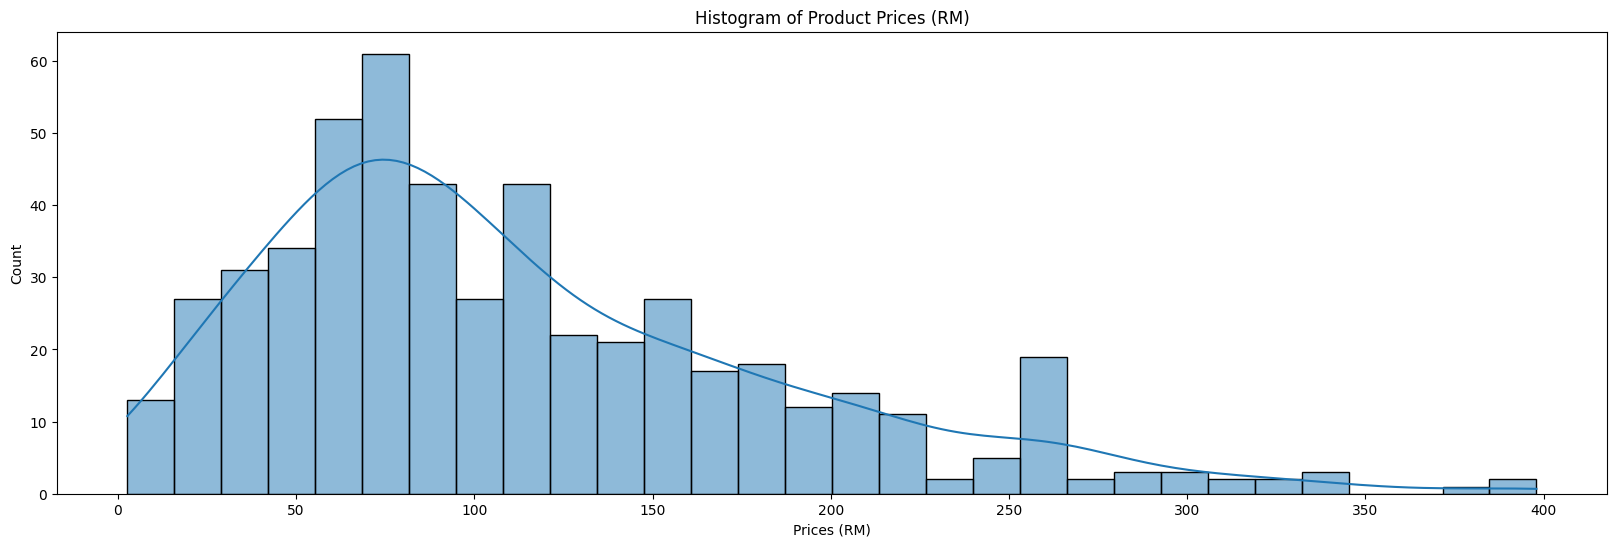

In [ ]:
# Creating histogram for 'Price' attribute
plt.figure(figsize=(20,6))
sns.histplot(data=df, x='Prices (RM)', kde=True, bins=30)

plt.title('Histogram of Product Prices (RM)')
plt.show()

In [ ]:
# Describe the data using maximum and minimum functions
max_value = df['Prices (RM)'].max()
min_value = df['Prices (RM)'].min()
data_description = df['Prices (RM)'].describe()


print(f"Maximum value of {'Prices (RM)'}: {max_value}")
print(f"Minimum value of {'Prices (RM)'}: {min_value}")
print("\nData Description:")
print(data_description)

Maximum value of Prices (RM): 398.0
Minimum value of Prices (RM): 2.65

Data Description:
count    517.000000
mean     113.499149
std       73.698114
min        2.650000
25%       61.300000
50%       93.600000
75%      153.480000
max      398.000000
Name: Prices (RM), dtype: float64


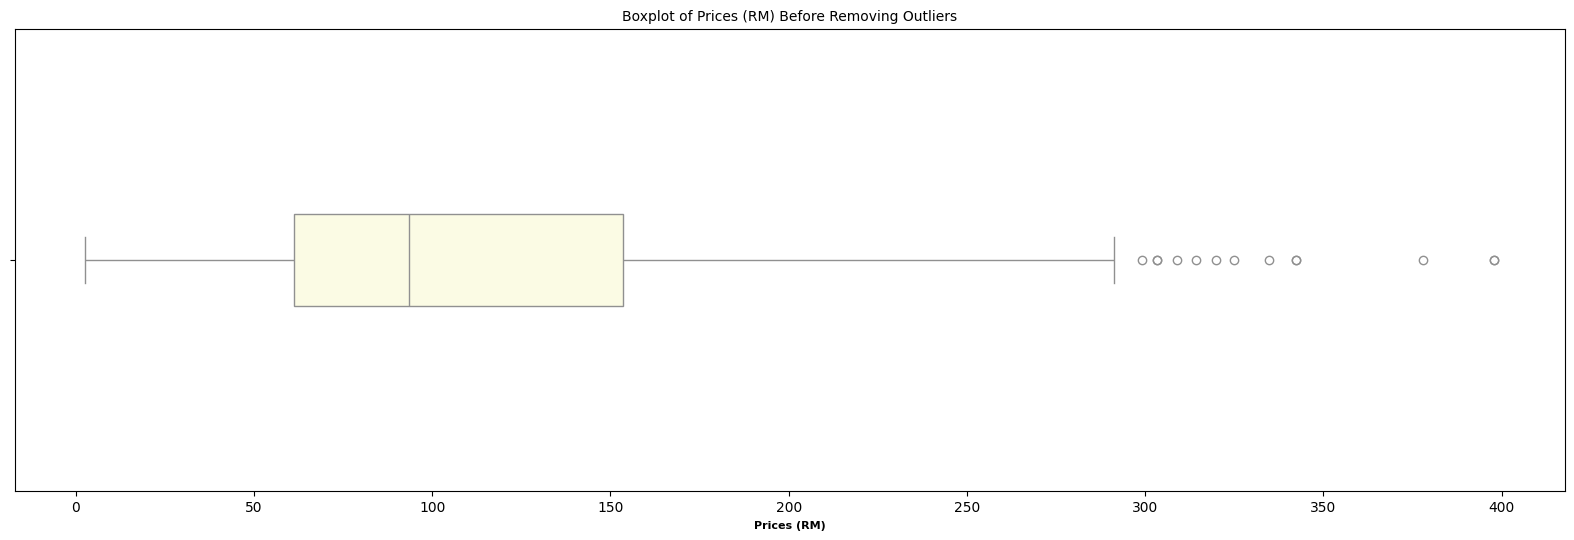

In [ ]:
# Before removing outlier
plt.figure(figsize=(20,6))
plot = sns.boxplot(x=df['Prices (RM)'],
                    width=0.2,
                    color="lightyellow")

plot.set_xlabel("Prices (RM)",
                fontsize=8, weight='bold')

plt.title('Boxplot of Prices (RM) Before Removing Outliers', fontsize=10)

plot.tick_params(labelsize=10)

In [ ]:
remove_outlier(df, 'Prices (RM)')

,Shop ID,Name,Prices (RM),Original Price (RM),Number of Reviews,Shipping Status,Rank Seller,Recommended,Rating
0,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
1,16050399,"Historic eighteenth century shoes, 18th centur...",170.28,170.28,1031,Paid Shipping,Star Seller,Recommended,4.94
2,34365344,Barefoot Women Boot | Brown Leather Boot | Ear...,110.50,780.30,2419,Free Shipping,Star Seller,Not Recommended,4.87
3,5774162,Women's Middle English - OLIVE,216.00,216.00,533,Free Shipping,Basic Seller,Recommended,4.98
4,34365344,Earth Shoe | Barefoot Sandale Women | Sandals ...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
...,...,...,...,...,...,...,...,...,...
512,22321483,Baby crawling shoes Mocca Leo dark blue with l...,45.41,45.41,105,Paid Shipping,Basic Seller,Recommended,5.00
513,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,Not Recommended,4.85
514,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,Basic Seller,Recommended,4.91
515,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Recommended,4.96


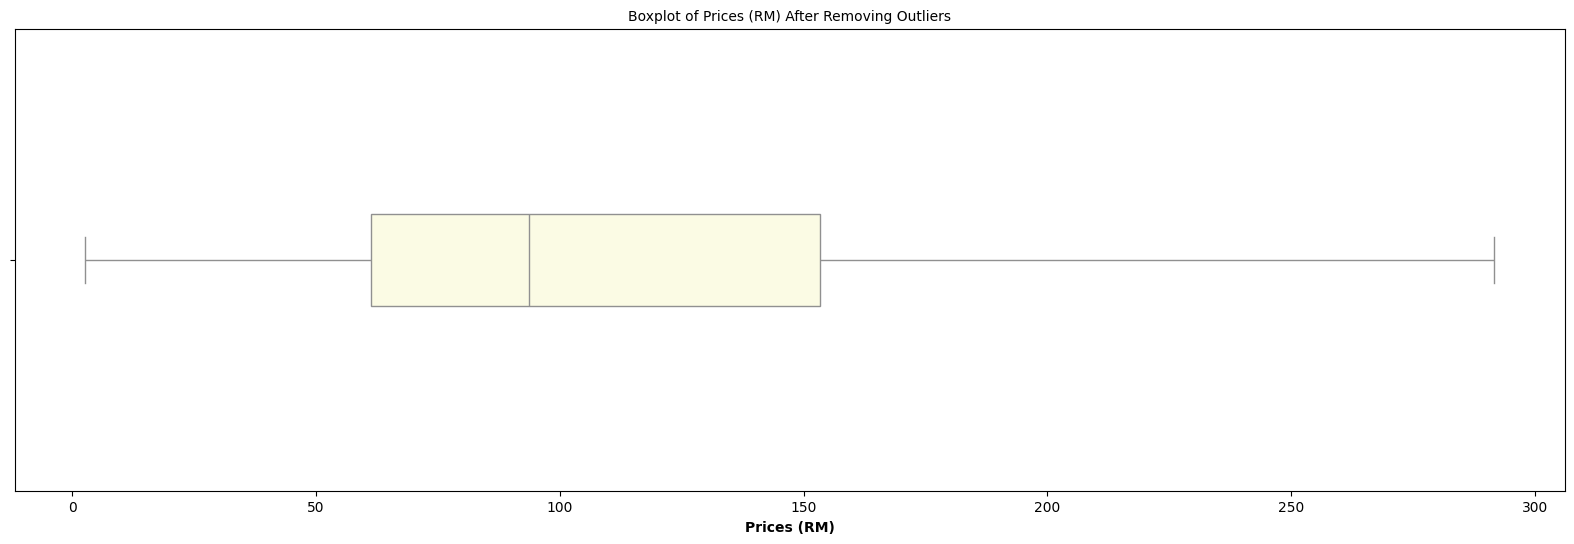

In [ ]:
# After removing outlier
plt.figure(figsize=(20,6))
plot = sns.boxplot(x=df['Prices (RM)'],
                    width=0.2,
                    color="lightyellow")

plot.set_xlabel("Prices (RM)",
                fontsize=10, weight='bold')

plt.title('Boxplot of Prices (RM) After Removing Outliers', fontsize=10)

plot.tick_params(labelsize=10)

In [ ]:
df['Prices (RM)'] = df['Prices (RM)'].round(decimals = 2)
df

,Shop ID,Name,Prices (RM),Original Price (RM),Number of Reviews,Shipping Status,Rank Seller,Recommended,Rating
0,34365344,Earth Shoe | Grounding Shoe | Barefoot Shoes W...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
1,16050399,"Historic eighteenth century shoes, 18th centur...",170.28,170.28,1031,Paid Shipping,Star Seller,Recommended,4.94
2,34365344,Barefoot Women Boot | Brown Leather Boot | Ear...,110.50,780.30,2419,Free Shipping,Star Seller,Not Recommended,4.87
3,5774162,Women's Middle English - OLIVE,216.00,216.00,533,Free Shipping,Basic Seller,Recommended,4.98
4,34365344,Earth Shoe | Barefoot Sandale Women | Sandals ...,78.00,550.80,2419,Free Shipping,Star Seller,Not Recommended,4.87
...,...,...,...,...,...,...,...,...,...
512,22321483,Baby crawling shoes Mocca Leo dark blue with l...,45.41,45.41,105,Paid Shipping,Basic Seller,Recommended,5.00
513,7939301,"Pink Ankle-Strap Sandals, Leather Sandals, Pin...",110.40,633.42,1868,Paid Shipping,Star Seller,Not Recommended,4.85
514,5286176,"OOAK kids slippers kittens, gift for cat lover...",52.22,52.22,3453,Free Shipping,Basic Seller,Recommended,4.91
515,11666639,"Baby pure merino wool booties, baby first hand...",21.57,21.57,1267,Paid Shipping,Star Seller,Recommended,4.96


### **SCATTERPLOT BETWEEN PRICES (RM) AND ORIGINAL PRICE (RM)**

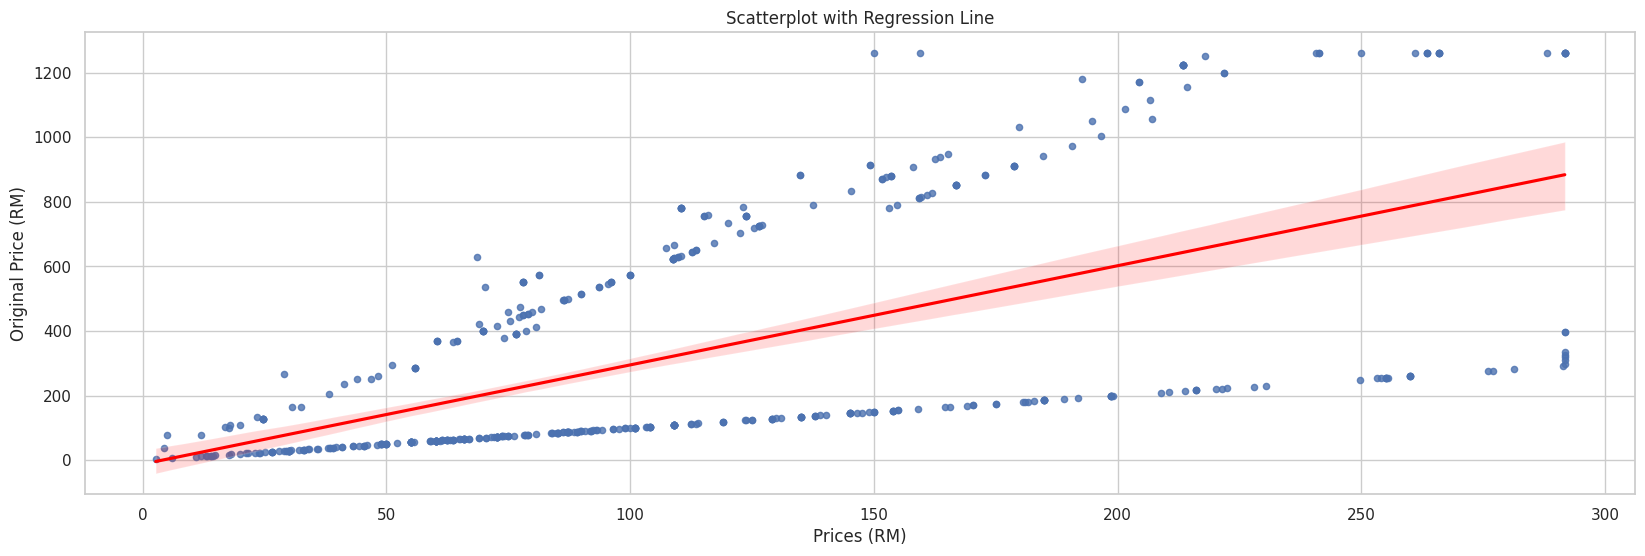

In [ ]:
# Assuming df is your DataFrame
sns.set(style="whitegrid")

# Scatterplot with regression line
plt.figure(figsize=(20, 6))
scatter_plot = sns.regplot(x='Prices (RM)', y='Original Price (RM)', data=df, scatter_kws={'s': 20}, line_kws={'color': 'red'})
scatter_plot.set(title='Scatterplot with Regression Line', xlabel='Prices (RM)', ylabel='Original Price (RM)')

plt.show()

### **SCATTERPLOT BETWEEN PRICES (RM) AND RATING ACCORDING TO RECOMMENDED**

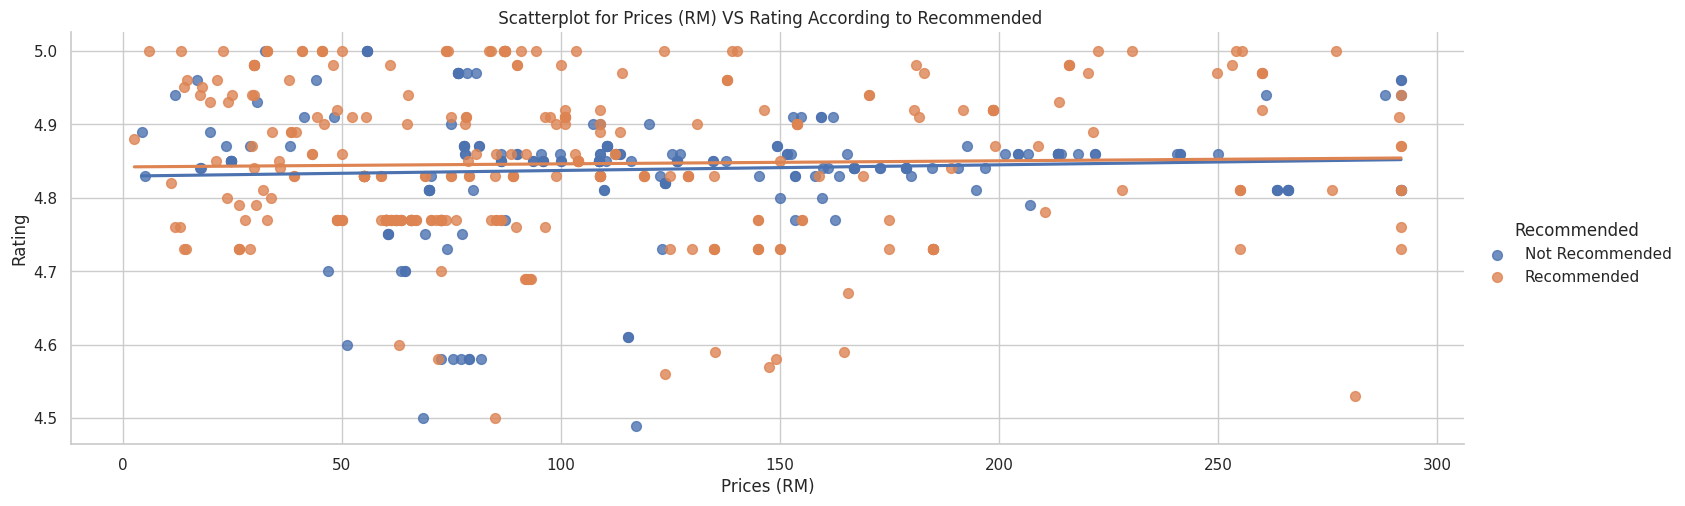

In [ ]:
# Set the size of the individual plots
scatter_kws = {"s": 50}  # Adjust the size as needed

# Set the aspect ratio (width) of the individual plots
aspect_ratio = 3  # Adjust the aspect ratio as needed

sns.lmplot(x="Prices (RM)",
           y="Rating",
           hue="Recommended",
           data=df,
           ci=None,
           height=5,  # Controls the height of the facet grid
           aspect=aspect_ratio,  # Controls the aspect ratio (width)
           scatter_kws=scatter_kws).set(title=" Scatterplot for Prices (RM) VS Rating According to Recommended")